In [9]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch.cuda.amp import GradScaler, autocast


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
IMG_SIZE = 32       # Input image size (CIFAR-10 default)
PATCH_SIZE = 4      # Patch size (Image size must be divisible by patch size)
NUM_CLASSES = 10    # Number of classes for CIFAR-10
DIM = 512           # Embedding dimension
DEPTH = 6           # Number of Transformer blocks
HEADS = 8           # Number of attention heads
MLP_DIM = 1024      # Hidden dimension in MLP
CHANNELS = 3        # Number of image channels
DROPOUT = 0.1       # Dropout rate
EMB_DROPOUT = 0.1   # Embedding dropout rate

LEARNING_RATE = 1e-4
BATCH_SIZE = 128
EPOCHS = 10



class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.heads = heads
        self.scale = (dim // heads) ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias = False)
        self.to_out = nn.Sequential(
            nn.Linear(dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: t.reshape(b, n, h, -1).transpose(1, 2), qkv)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = out.transpose(1, 2).reshape(b, n, -1)
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

# ViT Model
class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels = 3, dropout = 0., emb_dropout = 0.):
        super().__init__()
        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2

        self.patch_size = patch_size
        self.dim = dim

        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(channels, dim, kernel_size=patch_size, stride=patch_size),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, mlp_dim, dropout)

        self.to_latent = nn.Identity()
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        p = self.patch_size
        b = img.shape[0]
        x = self.to_patch_embedding(img)
        x = x.flatten(2)
        x = x.transpose(1, 2)

        cls_tokens = self.cls_token.expand(b, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        x += self.pos_embedding
        x = self.dropout(x)

        x = self.transformer(x)

        x = x[:, 0]
        x = self.to_latent(x)
        return self.mlp_head(x)


print("Loading CIFAR-10 dataset...")
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomCrop(IMG_SIZE, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
print("Dataset loaded.")


model = ViT(
    image_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
    num_classes=NUM_CLASSES,
    dim=DIM,
    depth=DEPTH,
    heads=HEADS,
    mlp_dim=MLP_DIM,
    dropout=DROPOUT,
    emb_dropout=EMB_DROPOUT
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


def train_one_epoch(epoch_idx):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch_idx+1}/{EPOCHS} [Training]")

    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'Loss': running_loss/(i+1), 'Acc': 100.*correct/total})

    return running_loss / len(trainloader), 100. * correct / total


def evaluate(epoch_idx):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(testloader), total=len(testloader), desc=f"Epoch {epoch_idx+1}/{EPOCHS} [Testing]")

    with torch.no_grad():
        for i, data in pbar:
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            with autocast():
               outputs = model(inputs)
               loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'Loss': running_loss/(i+1), 'Acc': 100.*correct/total})

    return running_loss / len(testloader), 100. * correct / total


print("Starting training...")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(epoch)
    test_loss, test_acc = evaluate(epoch)
    print(f"Epoch {epoch+1}/{EPOCHS} Summary | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%")

print('Finished Training')

Using device: cuda
Loading CIFAR-10 dataset...
Dataset loaded.
Starting training...


Epoch 1/10 [Training]:   0%|          | 0/391 [00:00<?, ?it/s]

<ipython-input-9-da163c747277>:212: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/10 [Testing]:   0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-9-da163c747277>:244: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(): # Use autocast for evaluation too


Epoch 1/10 Summary | Train Loss: 1.7692 Acc: 35.06% | Test Loss: 1.4767 Acc: 46.65%


Epoch 2/10 [Training]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10 [Testing]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/10 Summary | Train Loss: 1.4774 Acc: 46.29% | Test Loss: 1.3953 Acc: 51.05%


Epoch 3/10 [Training]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10 [Testing]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/10 Summary | Train Loss: 1.3638 Acc: 50.87% | Test Loss: 1.2614 Acc: 53.98%


Epoch 4/10 [Training]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10 [Testing]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/10 Summary | Train Loss: 1.2815 Acc: 53.86% | Test Loss: 1.2398 Acc: 55.83%


Epoch 5/10 [Training]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10 [Testing]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/10 Summary | Train Loss: 1.2220 Acc: 56.02% | Test Loss: 1.1516 Acc: 59.04%


Epoch 6/10 [Training]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10 [Testing]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/10 Summary | Train Loss: 1.1622 Acc: 58.38% | Test Loss: 1.0648 Acc: 61.61%


Epoch 7/10 [Training]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10 [Testing]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/10 Summary | Train Loss: 1.1184 Acc: 59.86% | Test Loss: 1.0567 Acc: 62.46%


Epoch 8/10 [Training]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10 [Testing]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/10 Summary | Train Loss: 1.0824 Acc: 61.19% | Test Loss: 1.0022 Acc: 64.18%


Epoch 9/10 [Training]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10 [Testing]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/10 Summary | Train Loss: 1.0372 Acc: 63.05% | Test Loss: 1.0004 Acc: 64.33%


Epoch 10/10 [Training]:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10 [Testing]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/10 Summary | Train Loss: 1.0039 Acc: 64.09% | Test Loss: 0.9563 Acc: 66.17%
Finished Training


In [2]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch.cuda.amp import GradScaler, autocast

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

pretrained_imgSize = 224
numClass = 10

ft_learnRate = 3e-5
batch_size = 64
EPOCHS = 5

scaler = GradScaler()

print("Loading pre-trained model...")
model = timm.create_model('vit_base_patch16_224.augreg_in21k', pretrained=True, num_classes=0)

embed_dim = model.embed_dim
print(f"Model embedding dimension: {embed_dim}")

model.head = torch.nn.Linear(embed_dim, numClass)
model = model.to(DEVICE)
print("Model loaded and head replaced.")

print("Loading CIFAR-10 dataset...")

transform_train = transforms.Compose([
    transforms.Resize((pretrained_imgSize, pretrained_imgSize)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform_test = transforms.Compose([
    transforms.Resize((pretrained_imgSize, pretrained_imgSize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
print("Dataset loaded.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=ft_learnRate, weight_decay=0.01)

def train_one_epoch(epoch_idx):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(trainloader), total=len(trainloader), desc=f"Epoch {epoch_idx+1}/{EPOCHS} [Training]")

    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        pbar.set_postfix({'Loss': running_loss/(i+1), 'Acc': f"{100.*correct/total:.2f}%"})

    return running_loss / len(trainloader), 100. * correct / total

def evaluate(epoch_idx):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(enumerate(testloader), total=len(testloader), desc=f"Epoch {epoch_idx+1}/{EPOCHS} [Testing]")

    with torch.no_grad():
        for i, data in pbar:
            inputs, labels = data
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            with autocast():
               outputs = model(inputs)
               loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            pbar.set_postfix({'Loss': running_loss/(i+1), 'Acc': f"{100.*correct/total:.2f}%"}) # Format acc

    return running_loss / len(testloader), 100. * correct / total

print("Starting fine-tuning...")
for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(epoch)
    test_loss, test_acc = evaluate(epoch)
    print(f"Epoch {epoch+1}/{EPOCHS} Summary | Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f} Acc: {test_acc:.2f}%")

print('Finished Fine-tuning')

Using device: cuda
Loading pre-trained model...


<ipython-input-2-53eea1a2a5d5>:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

Model embedding dimension: 768
Model loaded and head replaced.
Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:04<00:00, 40.5MB/s]


Dataset loaded.
Starting fine-tuning...


Epoch 1/5 [Training]:   0%|          | 0/782 [00:00<?, ?it/s]

<ipython-input-2-53eea1a2a5d5>:94: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/5 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

<ipython-input-2-53eea1a2a5d5>:125: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/5 Summary | Train Loss: 0.1580 Acc: 95.29% | Test Loss: 0.0817 Acc: 97.47%


Epoch 2/5 [Training]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2/5 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/5 Summary | Train Loss: 0.0389 Acc: 98.76% | Test Loss: 0.0685 Acc: 98.03%


Epoch 3/5 [Training]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3/5 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/5 Summary | Train Loss: 0.0289 Acc: 99.05% | Test Loss: 0.1082 Acc: 96.75%


Epoch 4/5 [Training]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4/5 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/5 Summary | Train Loss: 0.0264 Acc: 99.14% | Test Loss: 0.1087 Acc: 96.88%


Epoch 5/5 [Training]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5/5 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/5 Summary | Train Loss: 0.0229 Acc: 99.25% | Test Loss: 0.1110 Acc: 97.01%
Finished Fine-tuning


In [3]:
torch.save(model.state_dict(), "vit_finetuned_cifar10.pth")


In [4]:
model = timm.create_model('vit_base_patch16_224.augreg_in21k', pretrained=True, num_classes=0)
model.head = torch.nn.Linear(model.embed_dim, NUM_CLASSES)
model.load_state_dict(torch.load("vit_finetuned_cifar10.pth"))
model = model.to(DEVICE)
model.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

<ipython-input-17-3b5d1d5f99cb>:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Plotting results...


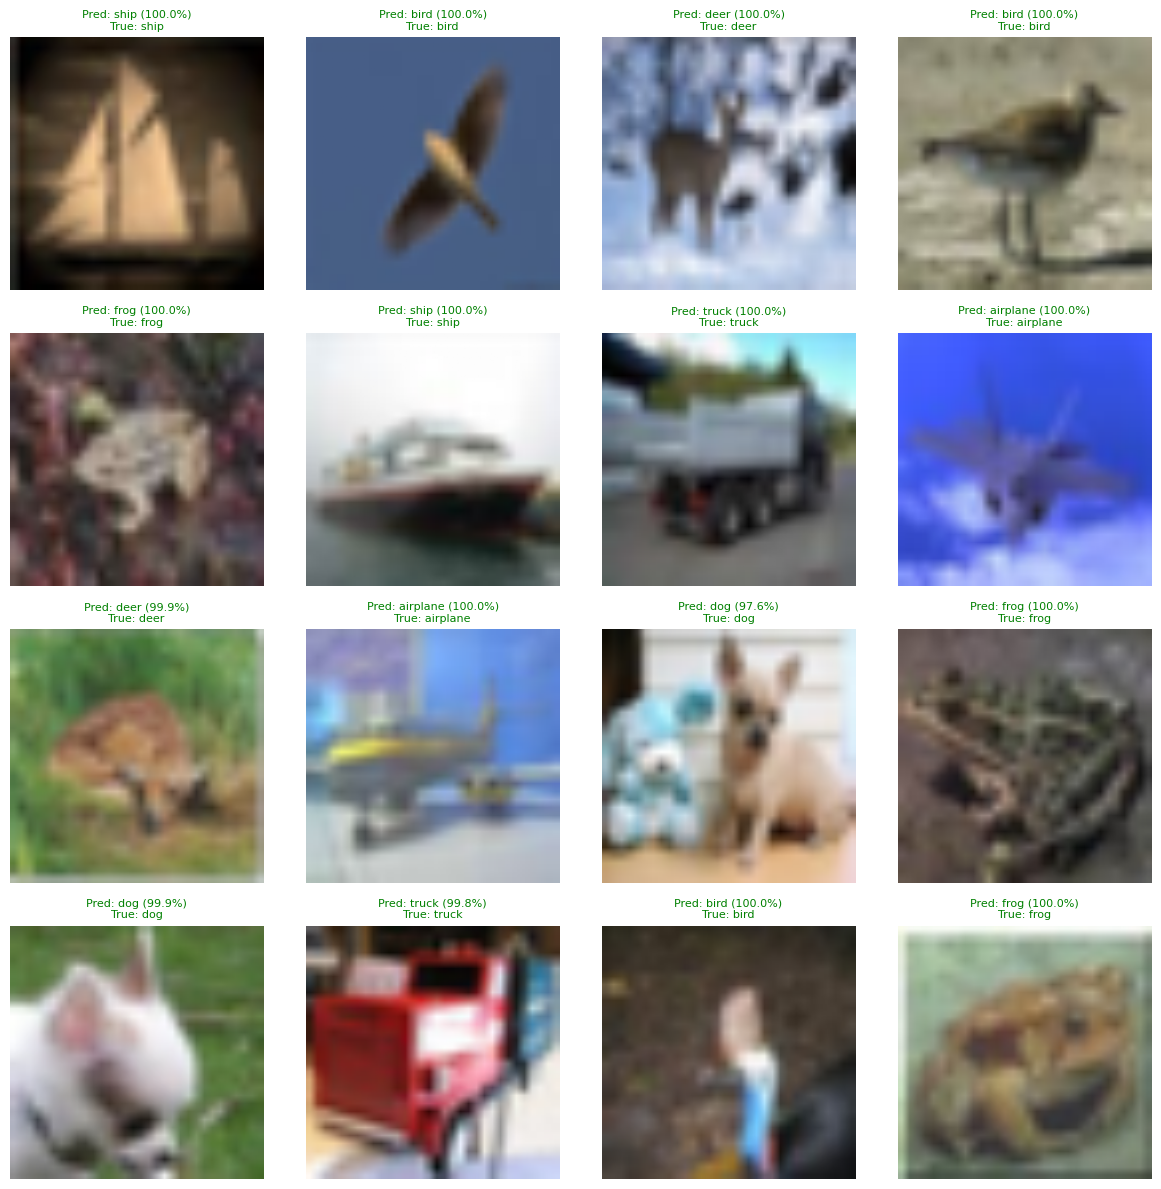

Visualization complete.


In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
# plotting the predictions
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4

model.eval()
classes = testset.classes

transform_display = transforms.Compose([
    transforms.Resize((PRETRAINED_IMG_SIZE, PRETRAINED_IMG_SIZE)),
    transforms.ToTensor(),
])

display_testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_display)

all_indices = list(range(len(testset)))
random_indices = random.sample(all_indices, NUM_IMAGES_TO_SHOW)

images_normalized = torch.stack([testset[i][0] for i in random_indices])
labels = torch.tensor([testset[i][1] for i in random_indices])

images_display = torch.stack([display_testset[i][0] for i in random_indices])

images_normalized = images_normalized.to(DEVICE)
labels = labels.to(DEVICE)

with torch.no_grad():
    with autocast():
        outputs = model(images_normalized)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_prob, predicted_class = torch.max(probabilities, 1)

images_display = images_display.cpu()
labels = labels.cpu()
predicted_class = predicted_class.cpu()
predicted_prob = predicted_prob.cpu()

def imshow_results(img_tensor, title):
    img_tensor = img_tensor.permute(1, 2, 0)
    plt.imshow(img_tensor)
    plt.title(title, fontsize=8)
    plt.axis('off')

print("Plotting results...")
fig = plt.figure(figsize=(12, 12))
num_rows = (NUM_IMAGES_TO_SHOW + NUM_COLS - 1) // NUM_COLS

for i in range(NUM_IMAGES_TO_SHOW):
    ax = fig.add_subplot(num_rows, NUM_COLS, i + 1, xticks=[], yticks=[])
    pred_name = classes[predicted_class[i]]
    true_name = classes[labels[i]]
    prob = predicted_prob[i].item() * 100
    title_color = 'green' if pred_name == true_name else 'red'
    plot_title = f"Pred: {pred_name} ({prob:.1f}%)\nTrue: {true_name}"
    imshow_results(images_display[i], plot_title)
    ax.title.set_color(title_color)

plt.tight_layout()
plt.show()
print("Visualization complete.")
